<center> <h1> Classification Supervisée : Approche naive et KNN-DTW </h1></center>

## I. Préliminaires

**chargement des librairies**

In [117]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator

# tslearn : for distance between curves/transition
from tslearn import metrics as tsm

# Data frame
import pandas as pd

# for barycenter
from tslearn import barycenters as tsb
from sklearn.model_selection import train_test_split
# For visualisation in 2D
from sklearn.manifold import TSNE
import plotly.express as px
# For score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd 
from sklearn.metrics import confusion_matrix
# Pour la visualisation de la matrice de confusion
import seaborn as sns
import math
from math import sqrt
import random
from dtaidistance import dtw
from scipy.spatial import distance
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

## Fonctions utiles

### Matrice de confusion

In [16]:
def create_confusion_matrix(y_pred, y_test,LABEL_NAMES):    
    #calculer la matrice de transition
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(confmat, cmap=plt.cm.Blues, alpha=2)

    n_labels = len(LABEL_NAMES)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(LABEL_NAMES)
    ax.set_yticklabels(LABEL_NAMES)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    

    ax.set_xlabel('Classe prédite')
    ax.set_ylabel('Vraie Classe')

    plt.tight_layout()
    plt.show()

In [96]:
def confmatrice(confmat):
    LABEL_NAMES=['wipe','dissolve','others']
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(confmat, cmap=plt.cm.Blues, alpha=2)
    
    n_labels = len(LABEL_NAMES)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(LABEL_NAMES)
    ax.set_yticklabels(LABEL_NAMES)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    ax.set_xlabel('Classe prédite')
    ax.set_ylabel('Vraie Classe')

    plt.tight_layout()
    plt.show()

### Variance de pixels

In [17]:
def variance(data):
    var = []
    for t in range(len(data)):
        transition = []
        for i in range(len(data[t])):
            if(data[t][i] is not None ):
                v=np.var(data[t][i], dtype=None)  
                transition.append(v)
            else:
                pass
        mean = np.mean(transition)
        sd = np.sqrt(np.var(transition))
          # Center
        transition_z_normalized = transition - mean
        if sd > 10 : 
            transition_z_normalized = transition_z_normalized/sd     
        var.append(transition_z_normalized)
    return var

### Histogramme

In [18]:
def histogramme(data):
    hist_freq = []
    
    for t in range(len(data)):
        transition = []
        for i in range(len(data[t])):
            # find frequency of pixels in range 0-255 
            pixel_freq = cv2.calcHist([data[t][i]],[0],None,[255],[0,255])
            transition.append(np.asarray(pixel_freq))
        # On append pour chaque transition
        hist_freq.append(transition)
        
    hist = []
    for t in range(len(hist_freq)):
        kumar_dist = consecutive_distance_Kumar(hist_freq[t])
        mean = np.mean(kumar_dist)
        sd = np.std(kumar_dist)
    
        kumar_dist_normalized = []
    # Center
        for d in range(len(kumar_dist)):
            kumar_dist_normalized.append(kumar_dist[d] - mean)
    # réduction
        if sd > 2.6 : 
            for d in range(len(kumar_dist_normalized)):
                kumar_dist_normalized[d] = kumar_dist_normalized[d]/sd
        
        hist.append(kumar_dist_normalized)
    return hist

### Nombre de contours

In [19]:
# on calcule le nombre de contour pour chaque transition
def Nbcontour(edges_img):
    edges = []
    for t in range(len(edges_img)):
        transition = []
        for i in range(len(edges_img[t])):      
            # Find contours and perform contour approximation
            cnts,_ = cv2.findContours(edges_img[t][i], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            nb_edge =0
            for c in cnts:
                peri = cv2.arcLength(c, True)
                approx = cv2.approxPolyDP(c, 0.0005 * peri, True)
                nb_edge = nb_edge + len(approx)
            transition.append(nb_edge)
            # Z-normalisation
        mean = np.mean(transition)
        sd = np.std(transition)
        if sd>0 :    
            edges_normalized = (transition - mean)/sd
        else :
            edges_normalized = transition/np.max(transition[0])
        edges.append(edges_normalized)
    
    return edges  

### Les fonctions de distances 

In [20]:
# Calcul de la distance par rapport au barycentre

def distance_par_rapport_au_barycentre(vecteur, barycentre):
    d = tsm.cdist_dtw([vecteur, barycentre], global_constraint = 'sakoe_chiba')
    return d[0,1]

# Calcul de la distance min d'appartenance à la classe 

def distance_min(vecteur_classe,barycentre):
    d=[]
    for k in range(len(vecteur_classe)):
        d.append(distance_par_rapport_au_barycentre(vecteur_classe[k], barycentre))
    return max(d)

def vectoriser(h):
    vec=[]
    for i in range(len(h)):
        vec.append(float(h[i]))
    return np.asarray(vec)

# distance entre 2 histogrammes

def pairwise_distance_Kumar(x,y):
    '''
    Compute pairwise distance between 2 histograms
    :param x: histo 1
    :type x: np array
    :param y: histo2
    :type y: np array
    :return: distance
    :rtype: float
    '''
    return np.sum(abs(x-y) / (1+x+y))

# distance consécutives entre histogrammes

def consecutive_distance_Kumar(features):
    '''
    Compute consecutive distances between elementwise of a list
    :param features: features extracted from images
    :type features: numpy array
    :return: consecutive distances between consecutive images
    :rtype: list
    '''
    N = len(features)
    dist = []
    for i in range(N-1):
        dist.append(pairwise_distance_Kumar(features[i],features[i+1]))
    return dist



### Les fonctions de prédictions 

In [21]:
# Prediction variance de pixels

def predict_var(X_test,k=3):
    variance_test=variance(X_test)
    y_pred=[]
    for i in range(len(variance_test)): 
        #Calcul distance
        dist = []
        for j in range(k) :
            dist.append(distance_par_rapport_au_barycentre(variance_test[i] , bar_class[j]))
        dist=np.array(dist)
        #Calcul probabilité distance.euclidean
        prob=[]
        for j in range(k):
            prob.append( np.exp(-dist[j]**2/2*np.var(dist) )/sum(np.exp(- dist**2/2*np.var(dist))) )
        y_pred.append(np.argmax(prob))
        
    return y_pred

# Prediction : variance de pixels 2
def predict_var1(data,k=3):
    variance_test=variance(data)
    y_pred=[]
    for i in range(len(variance_test)): 
        #Calcul distance
        dist = []
        for j in range(k) :
            dist.append(distance_par_rapport_au_barycentre(variance_test[i] , bar_class[j]))
        dist=np.array(dist)
        #Calcul probabilité distance.euclidean
        for j in np.argsort(dmin):
            if dist[j]<dmin[j] :
                y=j
        y_pred.append(y)
    return y_pred
# Prediction : variance de pixels 3
def predict_var2(data,k=3):
    variance_test=variance(data)
    y_pred=[]
    for i in range(len(variance_test)): 
        for j in range(k-1) :
            d=dtw.distance(variance_test[i] , bar_class[j])
            if d<dmin[j] :
                y=j
            else : 
                y=k
        y_pred.append(y)
    return y_pred

In [22]:
def predict_hist(X_test,k=3):
    histo=histogramme(X_test)
    y_pred=[]
    for i in range(len(histo)): 
        #Calcul distance
        dist = []
        for j in range(k) :
            dist.append(distance_par_rapport_au_barycentre(histo[i] , bar_classh[j]))
        dist=np.array(dist)
        #Calcul probabilité
        prob=[]
        for j in range(k):
            prob.append( np.exp(-dist[j]**2/2*np.var(dist) )/sum(np.exp(- dist**2/2*np.var(dist))) )
        y_pred.append(np.argmax(prob))
        
    return y_pred

In [23]:
def predict_edge(X_test,k=3):
    Edge_test=Nbcontour(X_test)
    y_pred=[]
    for i in range(len(Edge_test)): 
        #Calcul distance
        dist = []
        for j in range(k) :
            dist.append(distance_par_rapport_au_barycentre(Edge_test[i] , bar[j]))
        dist=np.array(dist)
        #Calcul probabilité
        prob=[]
        for j in range(k):
            prob.append( np.exp(-dist[j]**2/2*np.var(dist) )/sum(np.exp(- dist**2/2*np.var(dist))) )
        
        y_pred.append(np.argmax(prob))
        
    return y_pred

## Importation des données

In [24]:
data = []
for t in range(len(os.listdir("C:/Users/Adama/Desktop/data"))):
    # on se place dans un dossier transition t
    DIR = "C:/Users/Adama/Desktop/data/transition{}".format(t)  #r'C:/Users/Adama/Desktop/data/transition{}'.format(t)
    transition = []
    # on lit les images en gris dans le dossier transition t
    for i in range( len(os.listdir(DIR)) ):
        transition.append(cv2.imread(r'C:/Users/Adama/Desktop/data/transition{}/img{}.png'.format(t,i),0))
        
    data.append(transition)

In [25]:
del data[24]

In [26]:
transition_true_label = pd.read_excel('C:/Users/Adama/Desktop/transitions_types.xlsx')
transition_true_label = transition_true_label.drop(24)
transition_true_label.head(5)

,transitions,types
0,transition0,rétrécissement
1,transition1,wipe
2,transition2,wipe
3,transition3,wipe
4,transition4,fondu/dissolve


In [27]:
label=np.array(["rétrécissement","wipe","wipe","wipe","dissolve","wipe",
                "wipe","wipe","dissolve","dissolve","dissolve","dissolve","wipe","dissolve",
                "dissolve","dissolve","rotations verticales","dissolve","dissolve",
                "rotations horizontales","wipe","wipe","rotations verticales","dissolve",
                "dissolve","dissolve","dissolve","dissolve","dissolve","dissolve",
                "dissolve","dissolve","page tournée","wipe","wipe","page tournée"])
y=pd.Series(label).map({'wipe':0,'dissolve':1,'rétrécissement':2,'rotations verticales':2,'rotations horizontales':2,

                        'page tournée':2})

# VARIANCE DE PIXELS

In [106]:
n=30
recall=[]
precision=[]
matricedeconf=[]
for i in range(n):
    data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=16)
    
    var=variance(data_train)
    
    class_0=np.where(y_train==0)
    class_1=np.where(y_train==1)
    class_2=np.where(y_train==2)
    
    var_class_0 = []
    var_class_1 = []
    var_class_2 = []
    
    for t in list(class_0[0]):
        var_class_0.append(var[t])
        
    for t in list(class_1[0]):
        var_class_1.append(var[t])  
        
    for t in list(class_2[0]):
        var_class_2.append(var[t])
        
    bar_class_0 = tsb.dtw_barycenter_averaging(var_class_0)
    bar_class_1 = tsb.dtw_barycenter_averaging(var_class_1)
    bar_class_2 = tsb.dtw_barycenter_averaging(var_class_2)
    bar_class=[bar_class_0,bar_class_1,bar_class_2]
    
    y_pred=predict_var(data_test,k=3)
    label1=['wipe','dissolve','Autres'] 
    #print("Accuracy: %.2f%%" % (accuracy_score(y_pred, y_test) * 100.0))
    #create_confusion_matrix(y_pred, y_test,label1)
    
    a=precision_recall_fscore_support(y_test, y_pred, average='macro')
    recall.append(a[0]*100)
    precision.append(a[1]*100)
    matricedeconf.append(confusion_matrix(y_test, y_pred))
    

print(np.mean(precision))
print(np.mean(recall))

#print(matricedeconf)

52.440529100529105
40.892095558762236


### Matrice de confusion moyennée

In [94]:
M=np.zeros((3,3))
nb=0
for i in range(len(matricedeconf)):
    if M.shape == matricedeconf[i].shape :
        M=M+matricedeconf[i]
        nb=nb+1
print(M/nb)
print(np.around(M/nb,decimals=2))

[[1.20689655 2.06896552 1.20689655]
 [2.5862069  5.06896552 1.03448276]
 [1.27586207 0.27586207 1.27586207]]
[[1.21 2.07 1.21]
 [2.59 5.07 1.03]
 [1.28 0.28 1.28]]


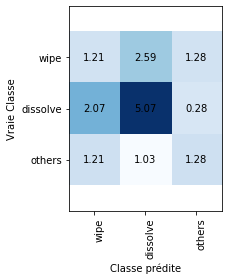

In [95]:
confmatrice(np.around(M/nb,decimals=2))

# HISTOGRAMME DE COULEURS

In [107]:
n=30
recall=[]
precision=[]
matricedeconf=[]
for i in range(n):
    data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=16)
    
    hist=histogramme(data_train)
    
    class_0=np.where(y_train==0)
    class_1=np.where(y_train==1)
    class_2=np.where(y_train==2)
    
    hist_class_0 = []
    hist_class_1 = []
    hist_class_2 = []
    
    for t in list(class_0[0]):
        hist_class_0.append(hist[t])
        
    for t in list(class_1[0]):
        hist_class_1.append(hist[t])  
        
    for t in list(class_2[0]):
        hist_class_2.append(hist[t])
        
    bar_0 = tsb.dtw_barycenter_averaging(hist_class_0)
    bar_1 = tsb.dtw_barycenter_averaging(hist_class_1)
    bar_2 = tsb.dtw_barycenter_averaging(hist_class_2)
    bar_classh=[bar_0,bar_1,bar_2]
    
    y_pred=predict_hist(data_test,k=3)
    label1=['wipe','dissolve','Autres'] 
    #print("Accuracy: %.2f%%" % (accuracy_score(y_pred, y_test) * 100.0))
    #create_confusion_matrix(y_pred, y_test,label1)
    
    a=precision_recall_fscore_support(y_test, y_pred, average='macro')
    recall.append(a[0]*100)
    precision.append(a[1]*100)
    matricedeconf.append(confusion_matrix(y_test, y_pred))
    

print(np.mean(precision))
print(np.mean(recall))

45.76374859708194
41.495149911816576


### Matrice de confusion moyennée

In [99]:
M=np.zeros((3,3))
nb=0
for i in range(len(matricedeconf)):
    if M.shape == matricedeconf[i].shape :
        M=M+matricedeconf[i]
        nb=nb+1
print(M/nb)
print(np.around(M/nb,decimals=0))

[[1.93333333 2.2        0.63333333]
 [1.96666667 3.8        2.8       ]
 [0.33333333 0.63333333 1.7       ]]
[[2. 2. 1.]
 [2. 4. 3.]
 [0. 1. 2.]]


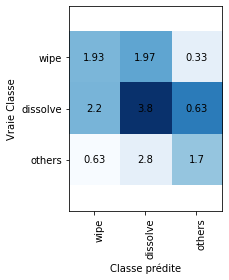

In [100]:
confmatrice(np.around(M/nb,decimals=2))

# NOMBRE DE CONTOURS 

In [108]:
n=30
recall=[]
precision=[]
matricedeconf=[]
for i in range(n):
    data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=16)
    
    Edge_train=Nbcontour(data_train)
    
    class_0=np.where(y_train==0)
    class_1=np.where(y_train==1)
    class_2=np.where(y_train==2)
    
    edges_class_0 = []
    edges_class_1 = []
    edges_class_2 = []
    
    for t in list(class_0[0]):
        edges_class_0.append(Edge_train[t])
        
    for t in list(class_1[0]):
        edges_class_1.append(Edge_train[t]) 
        
    for t in list(class_2[0]):
        edges_class_2.append(Edge_train[t])
        
    bar_0 = tsb.dtw_barycenter_averaging(edges_class_0)
    bar_1 = tsb.dtw_barycenter_averaging(edges_class_1)
    bar_2 = tsb.dtw_barycenter_averaging(edges_class_2)
    bar=[bar_0,bar_1,bar_2]
    
    y_pred=predict_edge(data_test,k=3)
    label1=['wipe','dissolve','Autres'] 
    #print("Accuracy: %.2f%%" % (accuracy_score(y_pred, y_test) * 100.0))
    #create_confusion_matrix(y_pred, y_test,label1)
    
    a=precision_recall_fscore_support(y_test, y_pred, average='macro')
    recall.append(a[0]*100)
    precision.append(a[1]*100)
    matricedeconf.append(confusion_matrix(y_test, y_pred))
    

print(np.mean(precision))
print(np.mean(recall))

32.05731922398589
34.933181016514354


### Matrice de confusion moyennée

In [103]:
M=np.zeros((3,3))
nb=0
for i in range(len(matricedeconf)):
    if M.shape == matricedeconf[i].shape :
        M=M+matricedeconf[i]
        nb=nb+1
print(M/nb)
print(np.around(M/nb,decimals=0))

[[1.5        1.03333333 2.56666667]
 [2.06666667 3.86666667 2.3       ]
 [1.36666667 0.73333333 0.56666667]]
[[2. 1. 3.]
 [2. 4. 2.]
 [1. 1. 1.]]


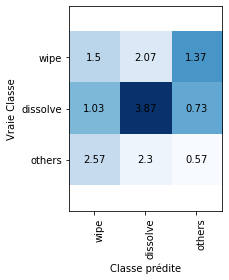

In [104]:
confmatrice(np.around(M/nb,decimals=2))

## Analyse des distances pour la caractéristique variance

In [159]:
def predict_vard(X_test,k=3):
    variance_test=variance(X_test)
    y_pred=[]
    distD=[]
    for i in range(len(variance_test)): 
        #Calcul distance
        dist = []
        for j in range(k) :
            dist.append(distance_par_rapport_au_barycentre(variance_test[i] , bar_class[j]))
        dist=np.array(dist)
        distD.append(dist)
        #Calcul probabilité distance.euclidean
        prob=[]
        distp=[]
        for j in range(k):
            prob.append( np.exp(-dist[j]**2/2*np.var(dist) )/sum(np.exp(- dist**2/2*np.var(dist))) )
        y_pred.append(np.argmax(prob))
        
    return y_pred,distD

In [177]:

data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=16)
    
var=variance(data_train)
    
class_0=np.where(y_train==0)
class_1=np.where(y_train==1)
class_2=np.where(y_train==2)
    
var_class_0 = []
var_class_1 = []
var_class_2 = []
    
for t in list(class_0[0]):
    var_class_0.append(var[t])
        
for t in list(class_1[0]):
    var_class_1.append(var[t])  
        
for t in list(class_2[0]):
    var_class_2.append(var[t])
        
bar_class_0 = tsb.dtw_barycenter_averaging(var_class_0)
bar_class_1 = tsb.dtw_barycenter_averaging(var_class_1)
bar_class_2 = tsb.dtw_barycenter_averaging(var_class_2)
bar_class=[bar_class_0,bar_class_1,bar_class_2]
    
y_pred,D=predict_vard(data_test,k=3)


In [178]:
col1=["D-barycentre0","D-barycentre1","D-barycentre2"]
col2=["Classe prédite"]
Df1=pd.DataFrame(D,index=y_test,columns=col1)
Df2=pd.DataFrame(y_pred,index=y_test,columns=col2)
Df=pd.concat([Df2,Df1],axis=1)
print(Df)

   Classe prédite  D-barycentre0  D-barycentre1  D-barycentre2
1               0       2.459989       2.883726       2.910311
1               1       3.320490       1.563020       3.418373
1               1       3.206017       1.629752       3.576828
1               1       2.809795       1.930945       3.496074
0               1       2.609696       2.099989       3.145314
2               1       3.978971       2.370044       3.008260
1               0       2.225024       2.722334       2.453082
1               1       2.512167       1.722968       3.406355
1               1       3.310547       2.177191       3.269410
2               0       1.704995       2.665633       2.398299
1               0       1.860242       2.344207       2.688723
2               2       1.804732       2.856092       1.413118
0               1       3.023876       2.814198       3.067632
2               0       2.206133       2.728965       2.287982
0               1       2.326181       1.991449       3

# KNN-DTW

# Fonctions Utiles

In [112]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [145]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return sqrt(LB_sum)

In [150]:
def knn_dtw(train,test,y_train,w):
    preds=[]
    y=y_train.tolist()
    for ind,i in enumerate(test):
        min_dist=float('inf')
        #print ind
        closest_seq=2 #Classes others
        for j in range(len(train)):
            if LB_Keogh(i[:-1],train[j],20)<min_dist:
                dist=DTWDistance(i[:-1],train[j],w)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=y[j]
        preds.append(closest_seq)
    return preds

# Variance de pixels

In [158]:
n=30
recall=[]
precision=[]
matricedeconf=[]
for i in range(n):
    data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=16)
    
    var=variance(data_train)
    var_test=variance(data_test)
    
    w=2
    y_pred=knn_dtw(var,var_test,y_train,w)

    label1=['wipe','dissolve','Autres'] 
    #print("Accuracy: %.2f%%" % (accuracy_score(y_pred, y_test) * 100.0))
    #create_confusion_matrix(y_pred, y_test,label1)
    
    a=precision_recall_fscore_support(y_test, y_pred, average='macro')
    recall.append(a[0]*100)
    precision.append(a[1]*100)
    matricedeconf.append(confusion_matrix(y_test, y_pred))
    

print(np.mean(precision))
print(np.mean(recall))

#print(matricedeconf)

59.3903318903319
54.208980833980824


In [152]:
M=np.zeros((3,3))
nb=0
for i in range(len(matricedeconf)):
    if M.shape == matricedeconf[i].shape :
        M=M+matricedeconf[i]
        nb=nb+1
print(M/nb)
print(np.around(M/nb,decimals=2))

[[0.93333333 2.63333333 1.5       ]
 [1.7        5.23333333 1.36666667]
 [1.13333333 1.         0.5       ]]
[[0.93 2.63 1.5 ]
 [1.7  5.23 1.37]
 [1.13 1.   0.5 ]]


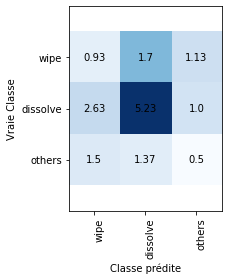

In [153]:
confmatrice(np.around(M/nb,decimals=2))

# Histogramme

In [154]:
n=30
recall=[]
precision=[]
matricedeconf=[]
for i in range(n):
    data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=16)
    
    hist=histogramme(data_train)
    hist_test=histogramme(data_test)
    
    y_pred=knn_dtw(hist,hist_test,y_train,w=4)
    label1=['wipe','dissolve','Autres'] 
    #print("Accuracy: %.2f%%" % (accuracy_score(y_pred, y_test) * 100.0))
    #create_confusion_matrix(y_pred, y_test,label1)
    
    a=precision_recall_fscore_support(y_test, y_pred, average='macro')
    recall.append(a[0]*100)
    precision.append(a[1]*100)
    matricedeconf.append(confusion_matrix(y_test, y_pred))
    

print(np.mean(precision))
print(np.mean(recall))

41.69620811287477
43.360694860694856


### Matrice de confusion moyennée

In [155]:
M=np.zeros((3,3))
nb=0
for i in range(len(matricedeconf)):
    if M.shape == matricedeconf[i].shape :
        M=M+matricedeconf[i]
        nb=nb+1
print(M/nb)
print(np.around(M/nb,decimals=0))

[[1.26666667 3.         0.76666667]
 [0.96666667 6.         1.2       ]
 [0.73333333 1.53333333 0.53333333]]
[[1. 3. 1.]
 [1. 6. 1.]
 [1. 2. 1.]]


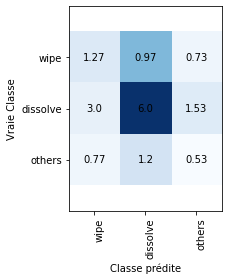

In [156]:
confmatrice(np.around(M/nb,decimals=2))

# Nombre de contours

In [157]:
n=30
recall=[]
precision=[]
matricedeconf=[]
for i in range(n):
    data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=16)
    
    Edge_train=Nbcontour(data_train)
    Edge_test=Nbcontour(data_test)
    
    y_pred=knn_dtw(Edge_train,Edge_test,y_train,w=4)
    label1=['wipe','dissolve','Autres'] 
    #print("Accuracy: %.2f%%" % (accuracy_score(y_pred, y_test) * 100.0))
    #create_confusion_matrix(y_pred, y_test,label1)
    
    a=precision_recall_fscore_support(y_test, y_pred, average='macro')
    recall.append(a[0]*100)
    precision.append(a[1]*100)
    matricedeconf.append(confusion_matrix(y_test, y_pred))
    

print(np.mean(precision))
print(np.mean(recall))

28.381954465287794
28.42885201218535


## Matrice de confusion moyennée

In [130]:
M=np.zeros((3,3))
nb=0
for i in range(len(matricedeconf)):
    if M.shape == matricedeconf[i].shape :
        M=M+matricedeconf[i]
        nb=nb+1
print(M/nb)
print(np.around(M/nb,decimals=0))

[[0.76666667 2.36666667 2.        ]
 [1.53333333 4.96666667 1.96666667]
 [0.93333333 1.43333333 0.03333333]]
[[1. 2. 2.]
 [2. 5. 2.]
 [1. 1. 0.]]


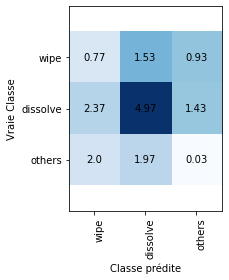

In [131]:
confmatrice(np.around(M/nb,decimals=2))